In [1]:
using JuMP, Gurobi, MathOptInterface, Random, CSV, DataFrames, Statistics, JLD2, FileIO, DelimitedFiles
import Base

model_type="model_with_k";
include("scripts/"*model_type*"/display.jl"); include("scripts/"*model_type*"/model.jl"); include("scripts/"*model_type*"/run.jl"); include("data/map_config.jl");

### Inputs

In [2]:
b4=Dict("Name"=> "4)", "Transfer"=> true, "Flexible" => true, "High capacity" => true); # We take high capacity busses + Flexible assign + Transfer

In [3]:
# Map Inputs
map_type="unif_map_1";

# Model Inputs
G = 0.3 # max detour ratio for customers (traveling time < (1+G)gamma)
Gtype= "shortestpathpercent" # or "absolutetime"
benchmark=b4

map_inputs,Wk,Q=create_inputs(map_type,benchmark);
(map_title,hubs_id,vbs_id,nb_locs,cust_id,nb_cust,depot_locs,horizon,tstep)=map_inputs

model_inputs = (G,Gtype,Wk,Q);

### Display map & create network

In [4]:
data, map1, tsnetwork, params, abbrev,pre_time, depot_locs = create_network(map_inputs, model_inputs,benchmark);
q, t, I, K=abbrev;

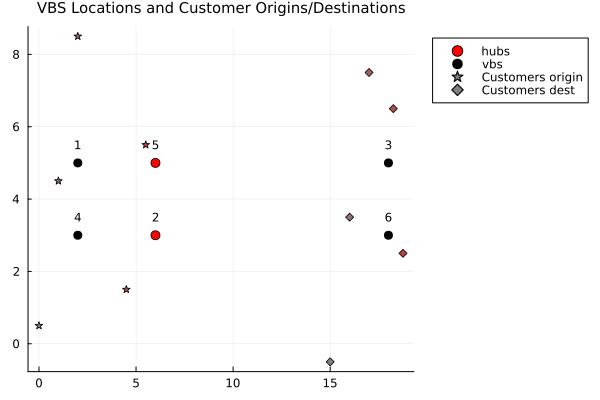

Cust 1, load 1 - Pick-up vbs: [1, 4], Drop-off vbs: [6], 	 depart at: 0.0, arrival before: 230.0
Cust 2, load 1 - Pick-up vbs: [1, 4], Drop-off vbs: [3, 6], 	 depart at: 10.0, arrival before: 180.0
Cust 3, load 1 - Pick-up vbs: [1], Drop-off vbs: [3, 6], 	 depart at: 20.0, arrival before: 230.0
Cust 4, load 1 - Pick-up vbs: [1, 2, 4, 5], Drop-off vbs: [3, 6], 	 depart at: 5.0, arrival before: 160.0
Cust 5, load 1 - Pick-up vbs: [1, 2, 4, 5], Drop-off vbs: [3, 6], 	 depart at: 15.0, arrival before: 140.0
Bus depot locations: 

Any[1, 4, 5]

In [5]:
# Show map
display(map1)
print_cust_bus_details(params,abbrev,depot_locs)

In [50]:
# Print number of nodes and arcs
#print_nb_arcs(tsnetwork,params,I)


In [51]:
# To visualize some arcs
#timespaceviz_arcs("viz.png", horizon, tstep, tsnetwork, tsnetwork.A_plus[56], x_size=2000, y_size=1000)

### Run model & Save results

In [52]:
# Model objective coefficients
mu=1 # coefficient in front of walking time
beta=1 # coefficient in front of waiting time
lambda=1 # transfer penalty
alpha1=1 # coefficient in front of vehicle driving time and utilization 
nu=20 # coefficient in front of vehicle utilization
alpha2=0 # coefficient in front of unmet demand
coefficients=mu,beta,lambda,alpha1,nu,alpha2;

In [53]:
sol=network_model(Q,abbrev,data.wo,tsnetwork,params,coefficients,0);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Objective value: 993.0832363243107


Save solution

In [54]:
save_res = true; # to save the results in the result folder
benchmark_name=string(benchmark["Name"])*"Tr_"*string(benchmark["Transfer"])*"_Flex_"*string(benchmark["Flexible"])*"_HighCap_"*string(benchmark["High capacity"])
resultfolder="results/"*model_type*"/"*map_type*"/"*benchmark_name*"/";
if save_res
    if !isdir("results/"*model_type*"/"*map_type*"/")
        mkdir("results/"*model_type*"/"*map_type*"/")
    end
    if !isdir(resultfolder)
        mkdir(resultfolder)
    end
    jldsave(resultfolder*".jld2", xi=sol.xi, x=sol.x, z=sol.z)
    write_result(resultfolder,sol,tsnetwork,params,abbrev,data.wo,false)
end

### Visualizations

In [55]:
#xi,x,z=load(result_file*".jld2", "xi", "x", "z");

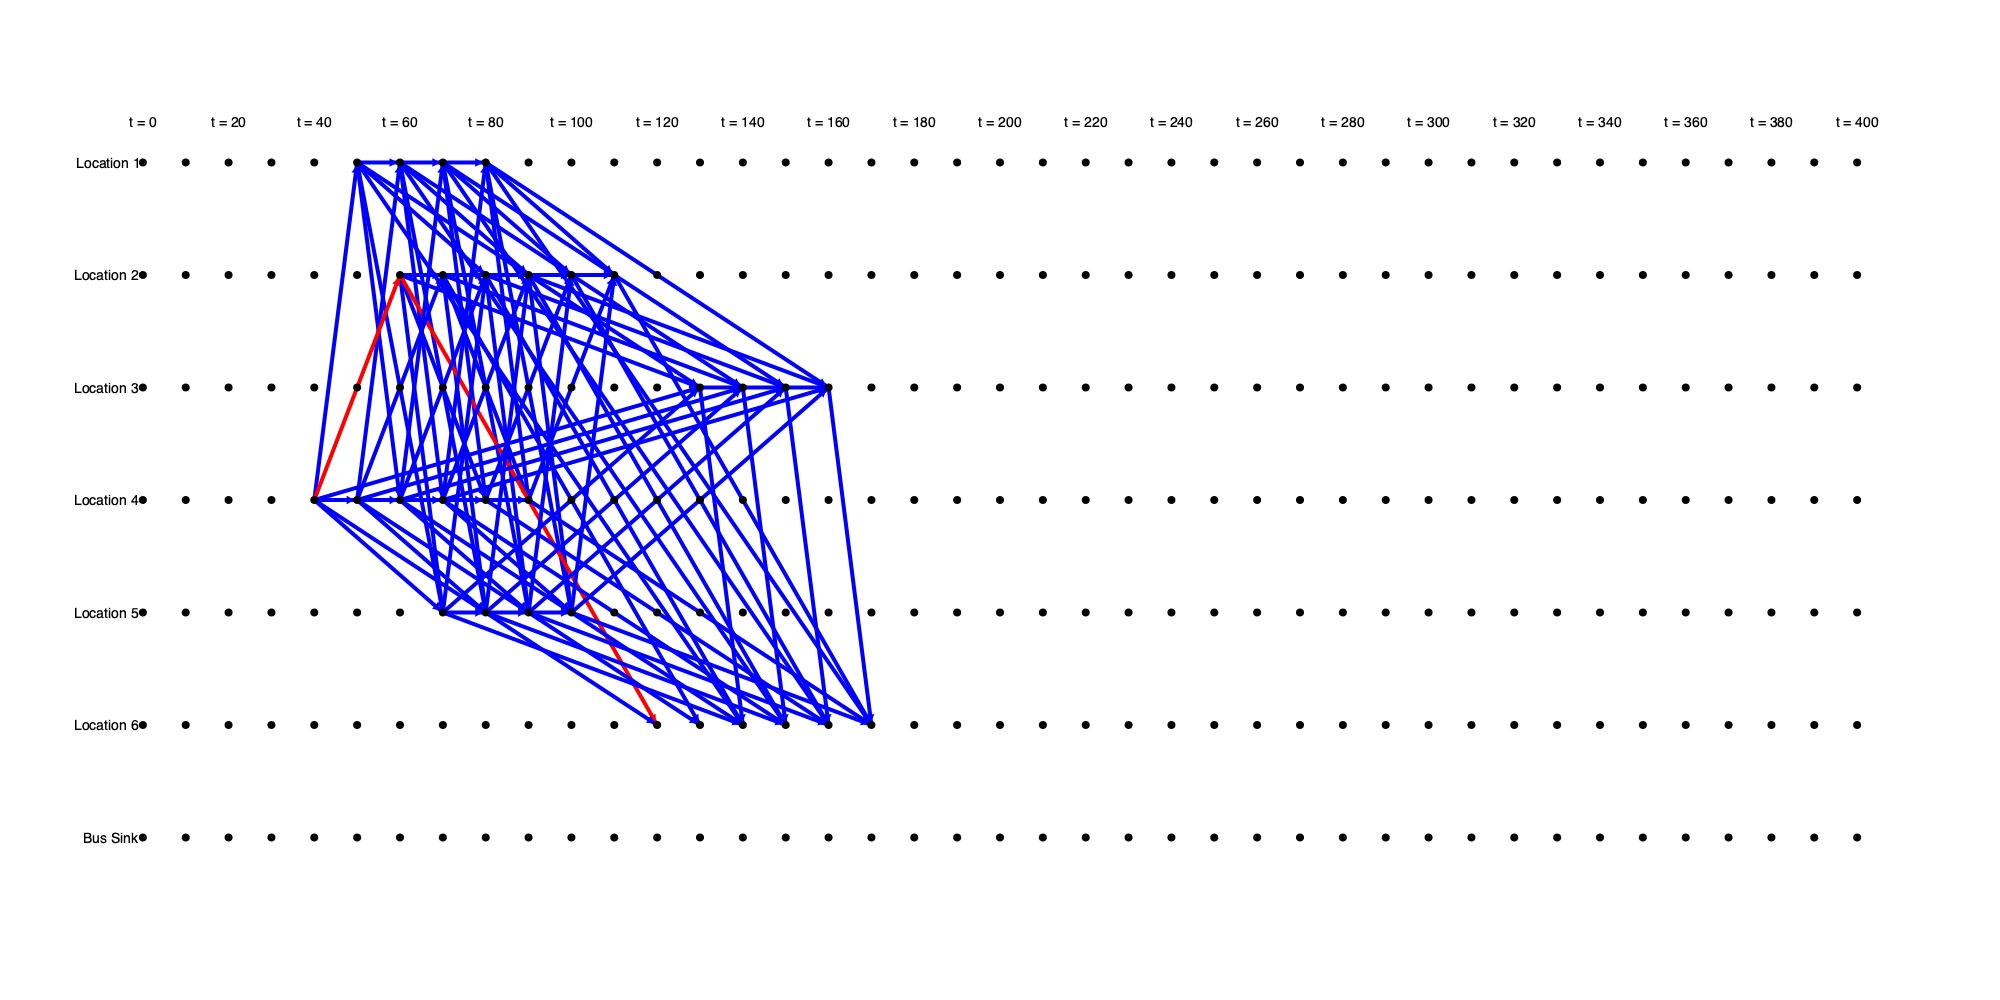

In [60]:
timespaceviz_arcs(resultfolder*"arcs_plot.png",horizon, tstep, tsnetwork, params.Ai[1],sol.x, params, K; x_size=2000, y_size=1000)

In [27]:
params.vo[1]

2-element Vector{Int64}:
 1
 4

In [28]:
params.vd[1]

1-element Vector{Int64}:
 6

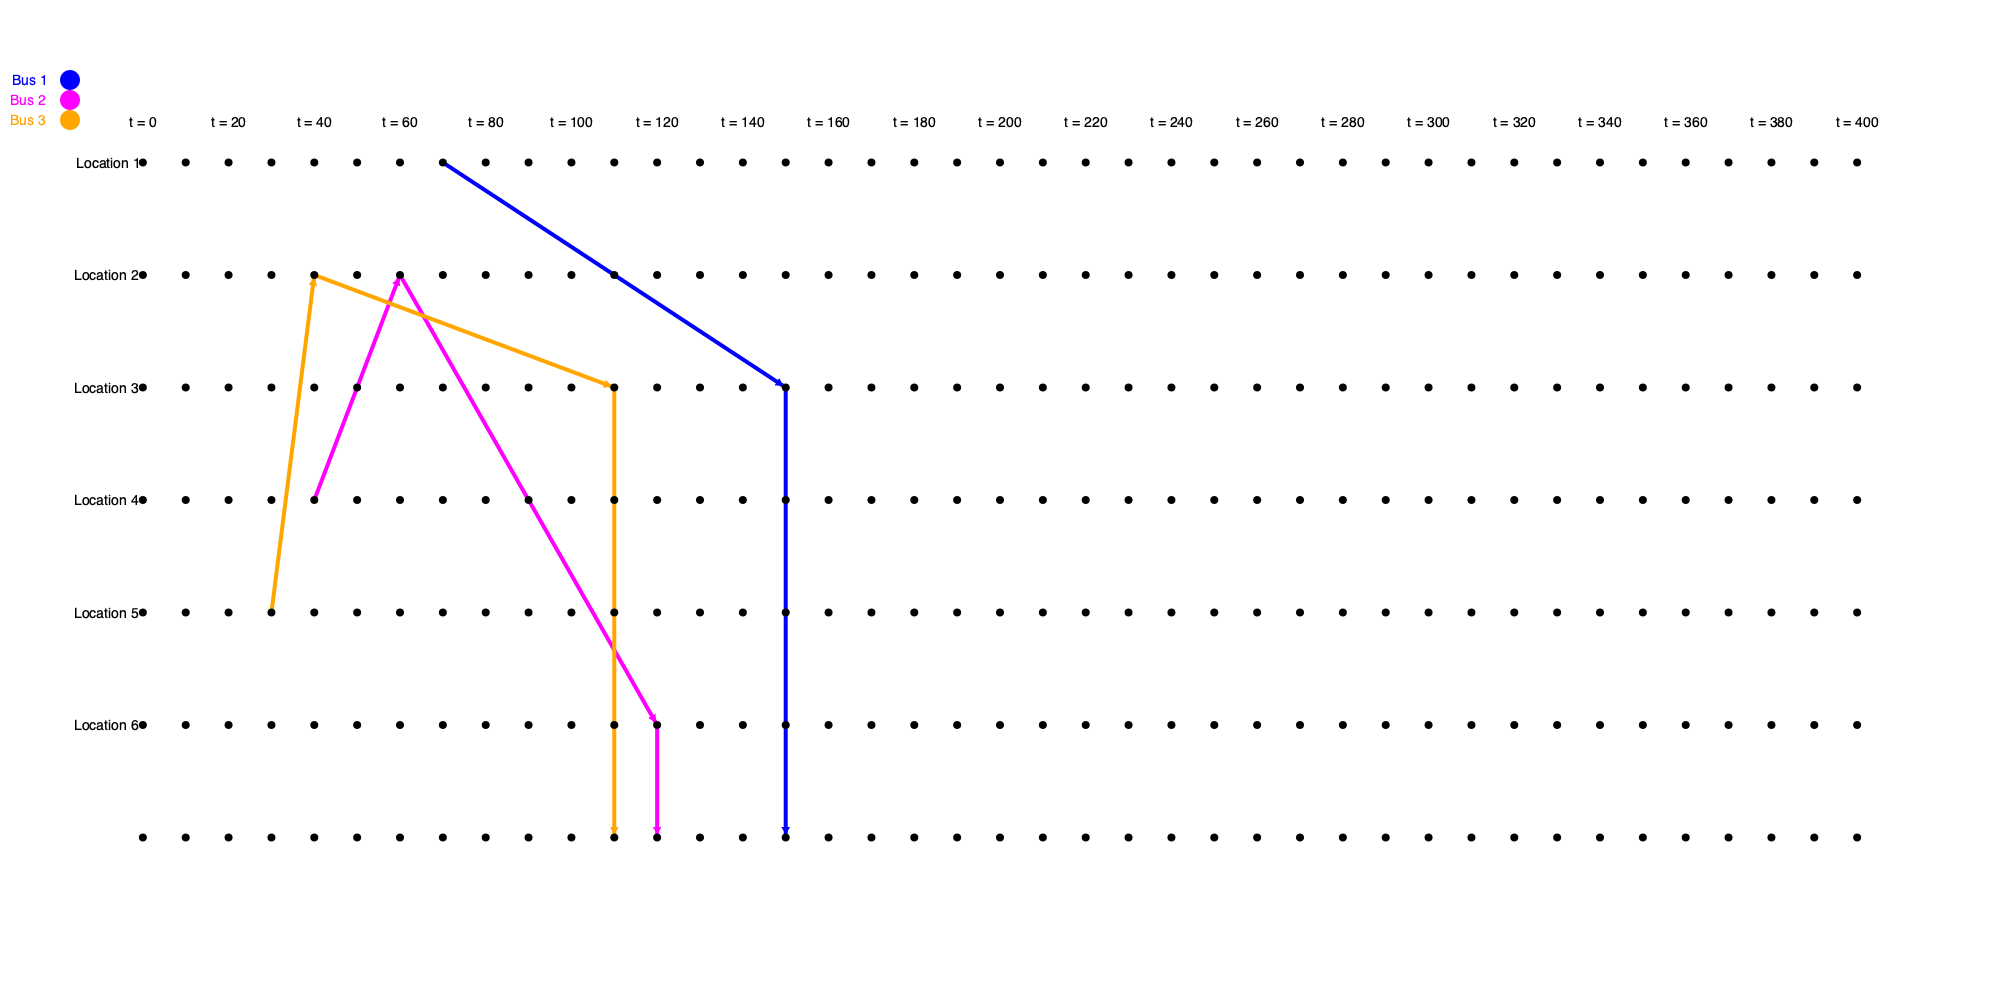

In [43]:
timespaceviz_bus(resultfolder*"tsplot.png", horizon, tstep, tsnetwork, params, sol.z, K, nb_locs, x_size=2000, y_size=1000)

In [14]:
ts=0 # time from which we want to print the arcs
map2=print_traveling_arcs(sol,ts,params,horizon,K,map1,data.locs,tsnetwork,nb_locs,true,save_res,resultfile)

UndefVarError: UndefVarError: resultfile not defined